### DCN

import+device

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cpu].


prepare dataset

In [12]:
from utils import create_dataset
dataset = create_dataset('movielens', device=device)
data = dataset.train_valid_test_split()
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = data
print(train_X[0,:]) # userID, movieID
print(train_y)   # like/dislike

tensor([  68, 2081])
tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])


cross network (这个不需要)

In [13]:
class CrossInteraction(nn.Module):
    def __init__(self, input_dim):
        super(CrossInteraction, self).__init__()
        self.weight = nn.Linear(input_dim, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(input_dim))

    def forward(self, X_0, X_i):
        interact_out = self.weight(X_i) * X_0 + self.bias
        return interact_out


class CrossNet(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(CrossNet, self).__init__()
        self.num_layers = num_layers
        self.cross_net = nn.ModuleList(CrossInteraction(input_dim)
                                       for _ in range(self.num_layers))

    def forward(self, X_0):
        X_i = X_0 # b x dim
        for i in range(self.num_layers):
            X_i = X_i + self.cross_net[i](X_0, X_i)
        return X_i

mlp_block

In [33]:
from fuxictr.pytorch.torch_utils import get_activation
class MLP_Block(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_units=[], 
                 hidden_activations="ReLU",
                 output_dim=True,
                 output_activation=None, 
                 dropout_rates=0.0,
                 batch_norm=False, 
                 bn_only_once=False, # Set True for inference speed up
                 use_bias=True):
        super(MLP_Block, self).__init__()
        dense_layers = []

        # check whether are lists
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
            
        hidden_activations = get_activation(hidden_activations, hidden_units)
        hidden_units = [input_dim] + hidden_units

        # batch normalization
        if batch_norm and bn_only_once:
            dense_layers.append(nn.BatchNorm1d(input_dim))

        # construct layers of mlp
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm and not bn_only_once:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
      
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if output_activation is not None:
            dense_layers.append(get_activation(output_activation))
            
        self.mlp = nn.Sequential(*dense_layers) # * used to unpack list
    
    def forward(self, inputs):
        return self.mlp(inputs)

In [54]:
class model(nn.Module):
    def __init__(self,
                 field_dims,
                 num_cross_layers,
                 dnn_hidden_units=[],
                 dnn_activations="ReLU",
                 net_dropout=0,
                 batch_norm=False,
                 embed_dim = 1):
        super(model, self).__init__()
        # embedding layer
        self.embedding_list = nn.ModuleList([nn.Embedding(dim, embed_dim) for dim in field_dims])
        input_dim = len(field_dims)
        # mlp layer
        self.dnn = MLP_Block(input_dim=input_dim,
                             output_dim=None, # output hidden layer
                             hidden_units=dnn_hidden_units,
                             hidden_activations=dnn_activations,
                             output_activation=None, 
                             dropout_rates=net_dropout,
                             batch_norm=batch_norm) \
                   if dnn_hidden_units else None # in case of only crossing net used
        self.crossnet = CrossNet(input_dim, num_cross_layers)
        self.fc=nn.Linear(input_dim,1)
    
    def forward(self, X):
        # embedding & stacking layer
        all_emb = torch.cat([embedding(X[:, i]) for i, embedding in enumerate(self.embedding_list)], dim = 1)
        corss_out=self.crossnet(all_emb)
        if self.dnn is not None:
            dnn_out=self.dnn(all_emb)
            final_out=torch.cat([corss_out,dnn_out],dim=-1)
        else:
            final_out=corss_out
        y_pred=self.fc(final_out)
        return F.sigmoid(y_pred)

Training

100%|██████████| 2000/2000 [05:21<00:00,  6.23it/s]


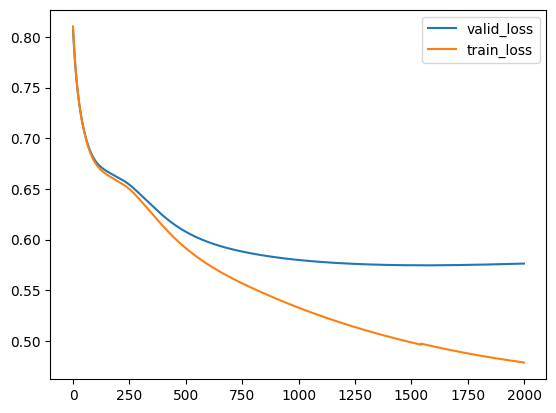

train_loss: 0.47862 | train_metric: 0.83928
valid_loss: 0.57626 | valid_metric: 0.76386
test_loss:  0.58437 | test_auc:  0.76397
CPU times: user 42min 46s, sys: 2.82 s, total: 42min 48s
Wall time: 5min 21s


In [57]:
%%time

from utils import Trainer
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 2000
TRIAL = 100
num_cross_layers = 4


mm = model(field_dims,num_cross_layers).to(device)
optimizer = torch.optim.Adam(mm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = torch.nn.BCELoss()

trainer = Trainer(mm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))